In [150]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from lmfit import minimize, Parameters, Parameter, report_fit
import matplotlib.pyplot as plt; plt.rc('font', size=16)
import matplotlib.cm as cm

cols = [cm.tab10(i) for i in range(10)]
cols.append(cm.Set2(5))
cols.append(cm.Paired(4))

In [34]:
params_ex = {'growth': np.array([3.5, 3.3, 4]), 'cross_int': np.array([[-1.2, 6, -4], [-5, -1.5, 4], [5, -5.5, -2]])}
x0_ex = np.array([0.5, 0.5, 0.5])
t_span_ex = [0, 10]
t_ex = np.linspace(t_span_ex[0], t_span_ex[1], 100)

def define_params(params=params_ex):
    p = Parameters()
    p.add('species', value=len(params['growth']), vary=False)
    for key, value in params.items():
        if key == 'growth':
            for i in range(len(value)):
                p.add(f'growth_{i+1}', value=value[i], min=0, vary=True)
        elif key == 'cross_int':
            for i in range(len(value)):
                for j in range(len(value)):
                    if i == j:
                        p.add(f'cross_int_{i+1}_{j+1}', value=value[i, j], max=0, vary=True)
                    else:
                        p.add(f'cross_int_{i+1}_{j+1}', value=value[i, j], vary=True)
    return p
params = define_params()
params

name,value,initial value,min,max,vary
species,3.00000000,3,-inf,inf,False
growth_1,3.50000000,3.5,0.00000000,inf,True
growth_2,3.30000000,3.3,0.00000000,inf,True
growth_3,4.00000000,4.0,0.00000000,inf,True
cross_int_1_1,-1.20000000,-1.2,-inf,0.00000000,True
cross_int_1_2,6.00000000,6.0,-inf,inf,True
cross_int_1_3,-4.00000000,-4.0,-inf,inf,True
cross_int_2_1,-5.00000000,-5.0,-inf,inf,True
cross_int_2_2,-1.50000000,-1.5,-inf,0.00000000,True
cross_int_2_3,4.00000000,4.0,-inf,inf,True


In [35]:
def gLV(x, t, params):
    growth = np.array([params[f'growth_{i+1}'].value for i in range(params['species'].value)])
    cross_int = np.array([[params[f'cross_int_{i+1}_{j+1}'].value for i in range(params['species'].value)] for j in range(params['species'].value)])

    inter = np.sum([x[i]*cross_int[i,j] for i in range(len(x)) for j in range(len(x))])

    return np.array([x[i]*(growth[i] + inter) for i in range(len(x))])

def solve_gLV(model=gLV, t_span=t_span_ex, x0=x0_ex, params=params, t_eval=t_ex):
    return solve_ivp(lambda t, x: model(x, t, params), t_span, x0, t_eval=t_eval)

def residuals(params, t, data):
    model = solve_gLV(params=params)
    return model.y - data

def fit_gLV(data, t, params=params):
    out = minimize(residuals, params, args=(t, data))
    return out

In [36]:
sol = solve_gLV()
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 116
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([ 0.        ,  0.1010101 ,  0.2020202 ,  0.3030303 ,  0.4040404 ,
        0.50505051,  0.60606061,  0.70707071,  0.80808081,  0.90909091,
        1.01010101,  1.11111111,  1.21212121,  1.31313131,  1.41414141,
        1.51515152,  1.61616162,  1.71717172,  1.81818182,  1.91919192,
        2.02020202,  2.12121212,  2.22222222,  2.32323232,  2.42424242,
        2.52525253,  2.62626263,  2.72727273,  2.82828283,  2.92929293,
        3.03030303,  3.13131313,  3.23232323,  3.33333333,  3.43434343,
        3.53535354,  3.63636364,  3.73737374,  3.83838384,  3.93939394,
        4.04040404,  4.14141414,  4.24242424,  4.34343434,  4.44444444,
        4.54545455,  4.64646465,  4.74747475,  4.84848485,  4.94949495,
        5.05050505,  5.15151515,  5.25252525,  5.35353535,  5.45454545,
        5.55555556,  5.656565

In [37]:
test_data = sol.y + np.random.normal(size=sol.y.shape)*0.1
test_t = sol.t

In [38]:
result = fit_gLV(test_data, test_t)
report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 114
    # data points      = 300
    # variables        = 12
    chi-square         = 2.94254035
    reduced chi-square = 0.01021715
    Akaike info crit   = -1363.35276
    Bayesian info crit = -1318.90737
[[Variables]]
    species:        3 (fixed)
    growth_1:       3.57863315 +/- 0.91515167 (25.57%) (init = 3.5)
    growth_2:       3.36317106 +/- 0.91549763 (27.22%) (init = 3.3)
    growth_3:       4.07444503 +/- 0.91435782 (22.44%) (init = 4)
    cross_int_1_1: -1.46045930 +/- 263852.102 (18066378.30%) (init = -1.2)
    cross_int_1_2:  6.27914645 +/- 324789.255 (5172506.44%) (init = 6)
    cross_int_1_3: -3.99685607 +/- 395814.401 (9903143.73%) (init = -4)
    cross_int_2_1: -5.25754988 +/- 157599.339 (2997581.43%) (init = -5)
    cross_int_2_2: -1.22429667 +/- 219501.970 (17928821.91%) (init = -1.5)
    cross_int_2_3:  4.00318745 +/- 384656.557 (9608757.08%) (init = 4)
    cross_int_3_1:  4.74324972 +/-

In [39]:
final = test_data + result.residual.reshape(test_data.shape)

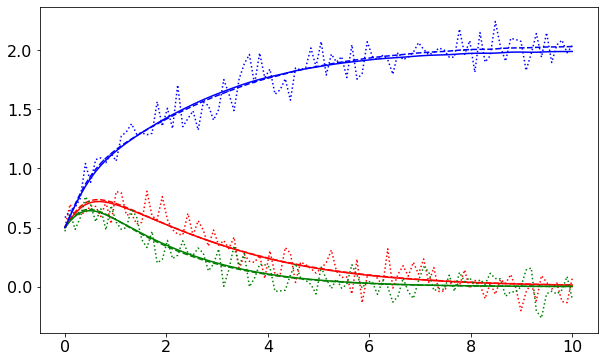

In [40]:
col = ['r', 'g', 'b']
plt.figure(figsize=(10, 6))
for i in range(len(col)):
    plt.plot(sol.t, sol.y[i], color=col[i])
    plt.plot(test_t, test_data[i], color=col[i], linestyle=':')
    plt.plot(test_t, final[i], color=col[i], linestyle='--')
plt.show()

***
# Test

In [41]:
dat = pd.read_pickle('COPROseq_absolute_abundance.pkl')
dat

,Strain,Treatment,Day,Absolute_abundance
0,B. caccae,LF0,1,7.841941e+06
1,B. caccae,LF0,1,4.797007e+07
2,B. cellulosilyticus WH2,LF0,1,9.625554e+06
3,B. cellulosilyticus WH2,LF0,1,6.622095e+07
4,B. ovatus,LF0,1,9.896323e+06
...,...,...,...,...
4843,C. scindens,HF0,42,4.633884e+07
4844,C. spiroforme,HF0,42,8.481661e+05
4845,D. longicatena,HF0,42,3.302648e+04
4846,P. distasonis,HF0,42,3.108796e+07


In [42]:
LF0_0 = dat[dat['Treatment'] == 'LF0'][dat['Day'] <=12].copy()
LF0_0

/tmp/ipykernel_27335/1704466875.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  LF0_0 = dat[dat['Treatment'] == 'LF0'][dat['Day'] <=12].copy()


,Strain,Treatment,Day,Absolute_abundance
0,B. caccae,LF0,1,7.841941e+06
1,B. caccae,LF0,1,4.797007e+07
2,B. cellulosilyticus WH2,LF0,1,9.625554e+06
3,B. cellulosilyticus WH2,LF0,1,6.622095e+07
4,B. ovatus,LF0,1,9.896323e+06
...,...,...,...,...
2023,C. scindens,LF0,12,5.219455e+07
2024,C. spiroforme,LF0,12,9.972200e+05
2025,D. longicatena,LF0,12,9.642167e+03
2026,P. distasonis,LF0,12,1.363388e+08


In [163]:
strain = LF0_0.Strain.unique()
x0 = np.array([LF0_0[LF0_0['Day'] == 1].groupby('Strain')['Absolute_abundance'].mean()[i] for i in strain])
x = np.array([LF0_0[LF0_0['Strain'] == i]['Absolute_abundance'].values for i in strain])
t = np.array([LF0_0[LF0_0['Strain'] == i]['Day'].values for i in strain])
t_span = [LF0_0.Day.values.min(), LF0_0.Day.values.max()]
t_eval = LF0_0.Day.unique()

def define_random_params(n=len(x)):
    p = Parameters()
    p.add('species', value=n, vary=False)
    for i in range(n):
        p.add(f'growth_{i+1}', value=np.random.uniform(0, 10), min=0, vary=True)
        for j in range(n):
            if i == j:
                p.add(f'cross_int_{i+1}_{j+1}', value=np.random.uniform(-5, 0), max=0, vary=True)
            else:
                p.add(f'cross_int_{i+1}_{j+1}', value=np.random.uniform(-5, 5), vary=True)
    return p

params = define_random_params()

In [164]:
def gLV(x, t, params):
    growth = np.array([params[f'growth_{i+1}'].value for i in range(params['species'].value)])
    cross_int = np.array([[params[f'cross_int_{i+1}_{j+1}'].value for i in range(params['species'].value)] for j in range(params['species'].value)])

    inter = np.sum([x[i]*cross_int[i,j] for i in range(len(x)) for j in range(len(x))])

    return np.array([x[i]*(growth[i] + inter) for i in range(len(x))])

def solve_gLV(model=gLV, t_span=t_span, x0=x0, params=params, t_eval=t_eval):
    return solve_ivp(lambda t, x: model(x, t, params), t_span, x0, t_eval=t_eval)

def residuals(params, t, data):
    model = solve_gLV(params=params)
    return model.y - data

def fit_gLV(data, t, params=params):
    out = minimize(residuals, params, args=(t, data))
    return out

In [165]:
result = fit_gLV(data=x, t=t, params=params)
final = x + result.residual.reshape(x.shape)
report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 157
    # data points      = 696
    # variables        = 156
    chi-square         = 6.4145e+19
    reduced chi-square = 1.1879e+17
    Akaike info crit   = 27499.3769
    Bayesian info crit = 28208.4514
##  Warning: uncertainties could not be estimated:
    growth_1:         at initial value
    cross_int_1_1:    at initial value
    cross_int_1_2:    at initial value
    cross_int_1_3:    at initial value
    cross_int_1_4:    at initial value
    cross_int_1_5:    at initial value
    cross_int_1_6:    at initial value
    cross_int_1_7:    at initial value
    cross_int_1_8:    at initial value
    cross_int_1_9:    at initial value
    cross_int_1_10:   at initial value
    cross_int_1_11:   at initial value
    cross_int_1_12:   at initial value
    growth_2:         at initial value
    cross_int_2_1:    at initial value
    cross_int_2_2:    at initial value
    cross_int_2_3:    at initial value
   

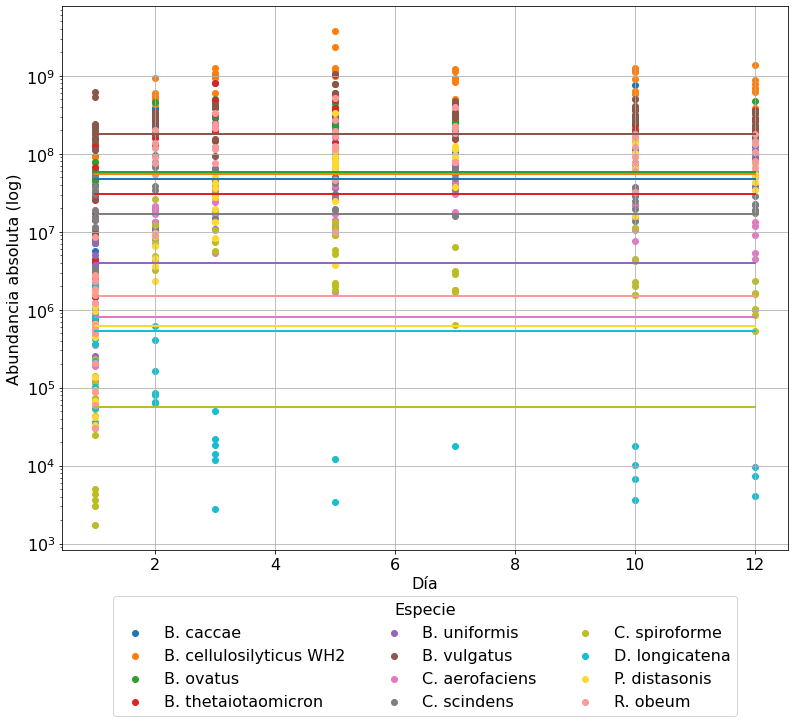

In [167]:
plt.figure(figsize=(13, 10))
for i in range(len(strain)):
    plt.scatter(t[i], x[i], label=strain[i], color=cols[i])
    plt.plot(t[i], final[i], linestyle='--', color=cols[i])
plt.yscale('log')
plt.xlabel('Día')
plt.ylabel('Abundancia absoluta (log)')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.32),
          ncol=3, fancybox=True, shadow=False, title='Especie')
plt.grid()
plt.show()

***
# Implementing perturbation term

In [168]:
dat = pd.read_pickle('COPROseq_absolute_abundance.pkl')
dat

,Strain,Treatment,Day,Absolute_abundance
0,B. caccae,LF0,1,7.841941e+06
1,B. caccae,LF0,1,4.797007e+07
2,B. cellulosilyticus WH2,LF0,1,9.625554e+06
3,B. cellulosilyticus WH2,LF0,1,6.622095e+07
4,B. ovatus,LF0,1,9.896323e+06
...,...,...,...,...
4843,C. scindens,HF0,42,4.633884e+07
4844,C. spiroforme,HF0,42,8.481661e+05
4845,D. longicatena,HF0,42,3.302648e+04
4846,P. distasonis,HF0,42,3.108796e+07


In [169]:
LF0 = dat[dat['Treatment'] == 'LF0'].copy()
LF0

,Strain,Treatment,Day,Absolute_abundance
0,B. caccae,LF0,1,7.841941e+06
1,B. caccae,LF0,1,4.797007e+07
2,B. cellulosilyticus WH2,LF0,1,9.625554e+06
3,B. cellulosilyticus WH2,LF0,1,6.622095e+07
4,B. ovatus,LF0,1,9.896323e+06
...,...,...,...,...
2263,C. scindens,LF0,42,1.840448e+07
2264,C. spiroforme,LF0,42,6.344682e+05
2265,D. longicatena,LF0,42,1.110101e+05
2266,P. distasonis,LF0,42,6.819918e+07


In [179]:
strain = LF0.Strain.unique()
x0 = np.array([LF0[LF0['Day'] == 1].groupby('Strain')['Absolute_abundance'].mean()[i] for i in strain])
x = np.array([LF0[LF0['Strain'] == i]['Absolute_abundance'].values for i in strain])
t = np.array([LF0[LF0['Strain'] == i]['Day'].values for i in strain])
t_span = [LF0.Day.values.min(), LF0.Day.values.max()]
t_eval = LF0.Day.unique()
C_LF = []
for i in LF0.Day.unique():
    if i <= 12:
        C_LF.append(0)
    elif i <= 25:
        C_LF.append(1)
    else:
        C_LF.append(0)
C_LF = np.array(C_LF)

def define_random_params(n=len(x)):
    p = Parameters()
    p.add('species', value=n, vary=False)
    for i in range(n):
        p.add(f'growth_{i+1}', value=np.random.uniform(0, 10), min=0, vary=True)
        p.add(f'perturbation_{i+1}', value=np.random.uniform(5, 5), vary=True)
        for j in range(n):
            if i == j:
                p.add(f'cross_int_{i+1}_{j+1}', value=np.random.uniform(-5, 0), max=0, vary=True)
            else:
                p.add(f'cross_int_{i+1}_{j+1}', value=np.random.uniform(-5, 5), vary=True)
    return p

params = define_random_params()

In [ ]:
def gLV(x, t, C, params):
    growth = np.array([params[f'growth_{i+1}'].value for i in range(params['species'].value)])
    cross_int = np.array([[params[f'cross_int_{i+1}_{j+1}'].value for i in range(params['species'].value)] for j in range(params['species'].value)])
    perturbation = np.array([params[f'perturbation_{i+1}'].value for i in range(params['species'].value)])

    inter = np.sum([x[i]*cross_int[i,j] for i in range(len(x)) for j in range(len(x))])
    suscept = np.sum([x[i]*perturbation[i] for i in range(len(x))])

    return np.array([x[i]*(growth[i] + inter + C*perturbation[i]) for i in range(len(x))])

def solve_gLV(model=gLV, t_span=t_span, x0=x0, params=params, t_eval=t_eval):
    return solve_ivp(lambda t, x: model(x, t, params), t_span, x0, t_eval=t_eval)

def residuals(params, t, data):
    model = solve_gLV(params=params)
    return model.y - data

def fit_gLV(data, t, params=params):
    out = minimize(residuals, params, args=(t, data))
    return out

In [ ]:
result = fit_gLV(data=x, t=t, params=params)
final = x + result.residual.reshape(x.shape)
report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 157
    # data points      = 696
    # variables        = 156
    chi-square         = 6.4145e+19
    reduced chi-square = 1.1879e+17
    Akaike info crit   = 27499.3769
    Bayesian info crit = 28208.4514
##  Warning: uncertainties could not be estimated:
    growth_1:         at initial value
    cross_int_1_1:    at initial value
    cross_int_1_2:    at initial value
    cross_int_1_3:    at initial value
    cross_int_1_4:    at initial value
    cross_int_1_5:    at initial value
    cross_int_1_6:    at initial value
    cross_int_1_7:    at initial value
    cross_int_1_8:    at initial value
    cross_int_1_9:    at initial value
    cross_int_1_10:   at initial value
    cross_int_1_11:   at initial value
    cross_int_1_12:   at initial value
    growth_2:         at initial value
    cross_int_2_1:    at initial value
    cross_int_2_2:    at initial value
    cross_int_2_3:    at initial value
   

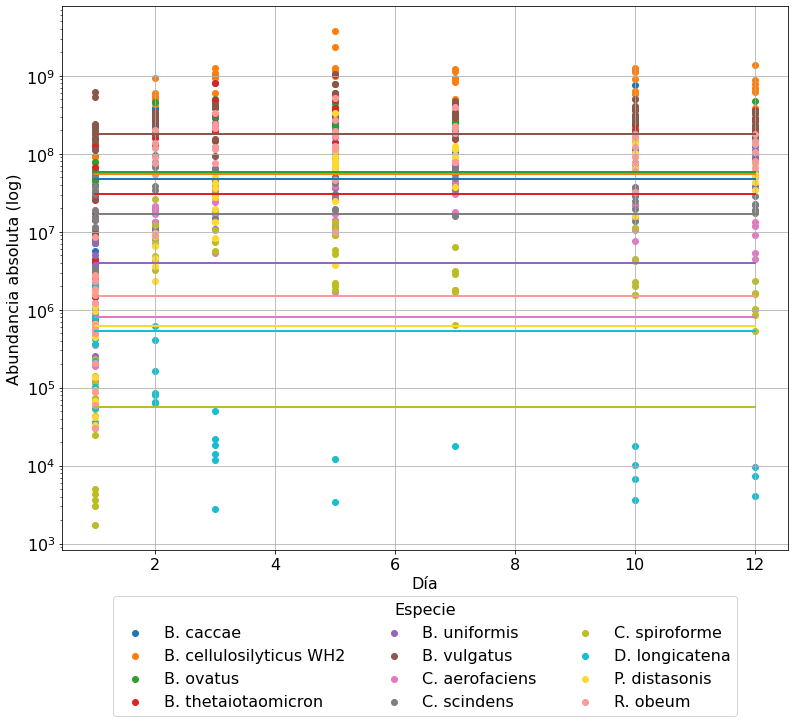

In [ ]:
plt.figure(figsize=(13, 10))
for i in range(len(strain)):
    plt.scatter(t[i], x[i], label=strain[i], color=cols[i])
    plt.plot(t[i], final[i], linestyle='--', color=cols[i])
plt.yscale('log')
plt.xlabel('Día')
plt.ylabel('Abundancia absoluta (log)')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.32),
          ncol=3, fancybox=True, shadow=False, title='Especie')
plt.grid()
plt.show()